In [41]:
import numpy as np
from numba import njit,prange
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd


## $$\text{Lithium VMC}$$
$$\Psi_{T1} = e^{-\alpha (r_1 +r_2 )}$$
$$\Psi_{T2} = e^{-\alpha (r_1 +r_2 )}(1 + \beta r_{12})$$
$$\Psi_{T3} = e^{-\alpha (r_1 +r_2 )}e^{\frac{r_{12}}{2(1 + \beta r_{12})}}$$


### $\text{Optimal alpha  using VMC for}$  
$$\Psi_{T1} = e^{-\alpha (r_1 +r_2 )}$$
<!-- $$\Psi_{T3} = e^{-\alpha (r_1 +r_2 )}e^{\frac{r_{12}}{2(1 + \beta r_{12})}}$$ -->


In [50]:
@njit(cache=True)
def trial_wavefunc_t1(r,alpha):
    n,d = r.shape
    argument = 0.0
    for i in range(r.shape[0]):
        r_single = 0.0
        for j in range(r.shape[1]):
            r_single += r[i,j]**2
        argument += math.sqrt(r_single)

    return np.exp(-argument * alpha) 

@njit(cache = True)
def local_energy_t1(r,alpha,charge):
    r1 = 0
    for i in range(3):
        r1 += r[0,i]**2
    r1 = math.sqrt(r1) 
       
    r2 = 0
    for i in range(3):
        r2 += r[1,i]**2
    r2 = math.sqrt(r2) 
       
    r12 = 0.0
    for k in range(3):
        r12 += (r[0,k]-r[1,k])**2
    r12 = math.sqrt(r12)
    
    E = (alpha - charge)*(1/r1 + 1/r2) + 1/r12 - alpha**2
    return E


@njit(cache = True)
def metropolis_sample_t1(r,alpha,charge,step,mcs):
    n,d = r.shape
    mean_energy = 0.0
    mean_sq_energy = 0.0
    r_old = r
    thermalisation = 1000
    # charge = 2
    for i in range(thermalisation):
        r_new = r_old + (np.random.random((n,d))- 0.5)*step
        wf_old = trial_wavefunc_t1(r_old,alpha)
        wf_new = trial_wavefunc_t1(r_new,alpha)

        if np.random.random() < (wf_new/wf_old)**2:
            r_old = r_new

    for i in range(mcs):
        r_new = r_old + (np.random.random((n,d)) - 0.5)*step
        wf_old = trial_wavefunc_t1(r_old,alpha)
        wf_new = trial_wavefunc_t1(r_new,alpha)

        if np.random.random() < (wf_new/wf_old)**2:
            r_old = r_new

        e = local_energy_t1(r_old,alpha,charge)
        mean_energy += e/mcs
        mean_sq_energy += e**2/mcs
    return  mean_energy,mean_sq_energy
      


In [87]:
number_cycles = 10**7
step_length = 1.0
h = 0.001
h2 = 1 / h**2
number_particle = 2
charge = 3
dimension = 3
num_alpha = 20
alpha = 2.2
r_old = step_length * (np.random.random((number_particle, dimension)) - 0.5)

mean_list_1 = np.zeros((num_alpha,3))
for i in tqdm(range(num_alpha)):
    alpha += 0.05
    mean_energy,mean_sq_energy = metropolis_sample_t1(r_old.copy(),alpha,charge,step_length,number_cycles)
    variance = mean_sq_energy - mean_energy**2
    mean_list_1[i] = np.array([alpha,mean_energy,variance])



100%|██████████| 20/20 [01:06<00:00,  3.31s/it]


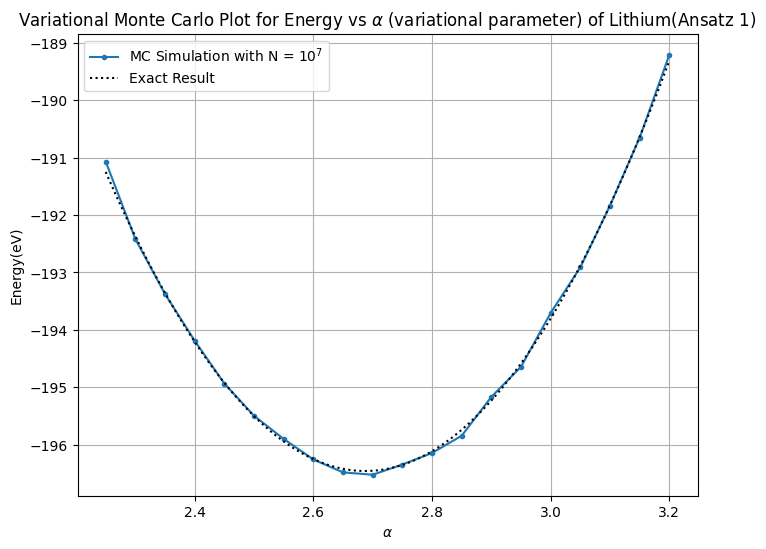

In [ ]:
alpha_list = np.linspace(2.25,3.2,100)
Energy_exact = lambda x: (x**2 - 6*x + 5/8 * x)*13.6*2

plt.figure(figsize=(8,6))
plt.plot(mean_list_1[:,0], 13.6*2*mean_list_1[:,1],'.-',label = 'MC Simulation with N = $10^7$')
plt.plot(alpha_list, Energy_exact(alpha_list),'k:',label = 'Exact Result')
plt.title('Variational Monte Carlo Plot for Energy vs $\\alpha$ (variational parameter) of Lithium (Ansatz 1)')
plt.xlabel('$\\alpha$')
plt.ylabel('Energy(eV)')
# plt.text(1.57,-76,'($E_{min}$,$\\alpha$) = (-77.46, 1.70)')
# plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

### $\text{Optimal Alpha and Beta using VMC for}$  
$$\Psi_{T2} = e^{-\alpha (r_1 +r_2 )}(1 + \beta r_{12})$$


In [48]:
@njit(cache=True)
def trial_wavefunc_t2(r,alpha,beta):
    n,d = r.shape
    argument = 0.0
    for i in range(r.shape[0]):
        r_single = 0.0
        for j in range(r.shape[1]):
            r_single += r[i,j]**2
        argument += math.sqrt(r_single)
    r12 = 0.0
    for j in range(d):
        r12 += (r[0][j] - r[1][j])**2
    r12 = r12**0.5 +10**-16 
    return np.exp(-argument * alpha)*(1 + beta*(r12))

@njit(cache = True)
def local_energy_t2(r,alpha,beta,charge):
    eps = 1e-9
    r1 = 0
    for i in range(3):
        r1 += r[0,i]**2
    r1 = math.sqrt(r1) + eps
       
    r2 = 0
    for i in range(3):
        r2 += r[1,i]**2
    r2 = math.sqrt(r2) + eps
       
    r12 = 0.0
    for k in range(3):
        r12 += (r[0,k]-r[1,k])**2
    r12 = math.sqrt(r12) + eps
    
    r1dotr2 = eps
    for i in range(3):
        r1dotr2 += r[0,i]*r[1,i]
        
    T_dot = (r1**2 - r2**2 + r12**2)/(2 * r1 * r12) + (r2**2 - r1**2 + r12**2)/(2 * r2 * r12)
    
    E = (alpha - charge)*(1/r1 + 1/r2) + 1/r12 - alpha**2 + beta/(1 + beta*r12) * (-2/r12 + alpha * T_dot) 
    return E

@njit(cache = True)
def metropolis_sample_t2(r,alpha,beta,charge,step,mcs):
    n,d = r.shape
    mean_energy = 0.0
    mean_sq_energy = 0.0
    r_old = r
    thermalisation = 1000
    # charge = 2
    for i in range(thermalisation):
        r_new = r_old + (np.random.random((n,d))- 0.5)*step
        wf_old = trial_wavefunc_t2(r_old,alpha,beta)
        wf_new = trial_wavefunc_t2(r_new,alpha,beta)

        if np.random.random() < (wf_new/wf_old)**2:
            r_old = r_new

    for i in range(mcs):
        r_new = r_old + (np.random.random((n,d)) - 0.5)*step
        wf_old = trial_wavefunc_t2(r_old,alpha,beta)
        wf_new = trial_wavefunc_t2(r_new,alpha,beta)

        if np.random.random() < (wf_new/wf_old)**2:
            r_old = r_new

        e = local_energy_t2(r_old,alpha,beta,charge)
        mean_energy += e/mcs
        mean_sq_energy += e**2/mcs
    return  mean_energy,mean_sq_energy
      


$\text{Beta optimisation for alpha found in Ansatz 1}$

In [4]:
number_cycles = 10**7
step_length = 1.0
number_particle = 2
charge = 3
dimension = 3
num_beta = 20
alpha = 2.70
beta = 0
r_old = step_length * (np.random.random((number_particle, dimension)) - 0.5)

mean_list_2 = np.zeros((num_beta,3))
for i in tqdm(range(num_beta)):
    beta += 0.025
    mean_energy,mean_sq_energy = metropolis_sample_t2(r_old.copy(),alpha,beta,charge,step_length,number_cycles)
    variance = mean_sq_energy - mean_energy**2
    mean_list_2[i] = np.array([beta,mean_energy,variance])



  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


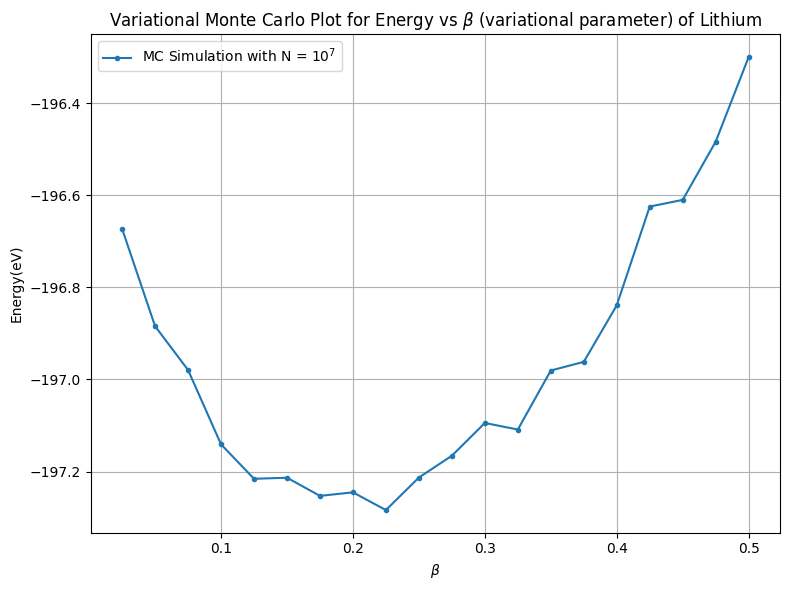

In [5]:
plt.figure(figsize=(8,6))
plt.plot(mean_list_2[:,0], 13.6*2*mean_list_2[:,1],'.-',label = 'MC Simulation with N = $10^7$')
plt.title('Variational Monte Carlo Plot for Energy vs $\\beta$ (variational parameter) of Lithium')
plt.xlabel('$\\beta$')
plt.ylabel('Energy(eV)')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

In [95]:
i = np.argmin(mean_list_2[:,1])
print('Optimal value of beta :',mean_list_2[i,0])

Optimal value of beta : 0.24999999999999997



$\text{Both alpha and beta optimisation}$

In [44]:
number_cycles = 2*10**6  
step_length = 1.0
h = 0.001
h2 = 1 / h**2
number_particle = 2
dimension = 3
num_alpha = 10
num_beta = 10
charge = 3
alpha_values = np.linspace(2.3, 3.2, num_alpha)
beta_values = np.linspace(0, 0.8, num_beta)

r_old = step_length * (np.random.random((number_particle, dimension)) - 0.5)

results_2 = np.zeros((num_alpha * num_beta, 4))

index = 0
for alpha in tqdm(alpha_values, desc='Alpha loop'):
    for beta in beta_values:
        mean_energy, mean_sq_energy = metropolis_sample_t2(r_old.copy(), alpha, beta,charge, step_length, number_cycles)
        variance = mean_sq_energy - mean_energy**2
        results_2[index] = np.array([alpha, beta, mean_energy, variance])
        index += 1
        

# print(results)

Alpha loop: 100%|██████████| 10/10 [01:14<00:00,  7.46s/it]


In [155]:
arg = 0
min_ = results_2[0][2]
for i in range(len(results_2)):
    if results_2[i,2] < min_:
        min_ = results_2[i,2]
        arg = i
print('Optimal Value of alpha and beta are',results_2[arg,0],'and',results_2[arg,1])        
# results

Optimal Value of alpha and beta are 2.8 and 0.26666666666666666


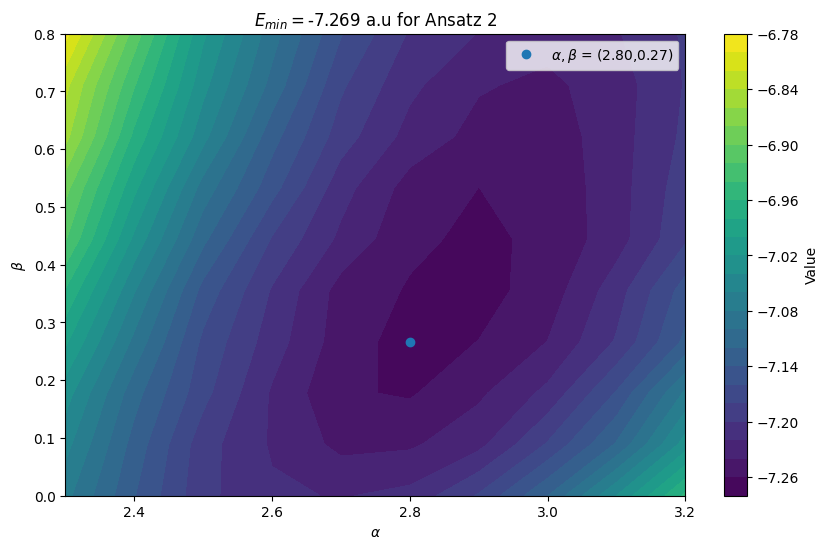

In [45]:
alpha_vals = results_2[:, 0]
beta_vals = results_2[:, 1]
energy_vals = results_2[:, 2]
unique_alpha = np.unique(alpha_vals)
unique_beta = np.unique(beta_vals)

Alpha, Beta = np.meshgrid(unique_alpha, unique_beta, indexing='ij')

energy_grid = energy_vals.reshape((len(unique_alpha), len(unique_beta)))
min_idx = np.argmin(energy_vals)
min_alpha_2 = alpha_vals[min_idx]
min_beta_2 = beta_vals[min_idx]
min_energy_2 = energy_vals[min_idx]
plt.figure(figsize=(10,6))
plt.contourf(Alpha,Beta,energy_grid,levels = 30)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('$E_{min} = $%0.3f a.u for Ansatz 2'%min_energy_2)
plt.plot(min_alpha_2,min_beta_2,'o',label= '$\\alpha,\\beta$ = (%0.2f,%0.2f)'%(min_alpha_2,min_beta_2))
plt.colorbar(label='Value')
plt.legend()

### $\text{Optimal Alpha and Beta using VMC for}$  
<!-- $$\Psi_{T1} = e^{-\alpha (r_1 +r_2 )}$$ -->
$$\Psi_{T3} = e^{-\alpha (r_1 +r_2 )}e^{\frac{r_{12}}{2(1 + \beta r_{12})}}$$

In [52]:
# alpha = 1.70
@njit(cache=True)
def trial_wavefunc_t3(r,alpha ,beta):
    n,d = r.shape
    argument = 0.0
    for i in range(r.shape[0]):
        r_single = 0.0
        for j in range(r.shape[1]):
            r_single += r[i,j]**2
        argument += math.sqrt(r_single)
    r12 = 0.0
    for j in range(d):
        r12 += (r[0][j] - r[1][j])**2
    r12 = r12**0.5 +10**-16 
    return np.exp(-argument * alpha)*np.exp((r12)/(2 + 2* beta*(r12)))

@njit(cache = True)
def local_energy_t3(r,alpha,beta,charge):
    r1 = 0
    for i in range(3):
        r1 += r[0,i]**2
    r1 = math.sqrt(r1) 
       
    r2 = 0
    for i in range(3):
        r2 += r[1,i]**2
    r2 = math.sqrt(r2) 
       
    r12 = 0.0
    for k in range(3):
        r12 += (r[0,k]-r[1,k])**2
    r12 = math.sqrt(r12)
    
    r1dotr2 = 0
    for i in range(3):
        r1dotr2 += r[0,i]*r[1,i]
    
    E = (alpha - charge)*(1/r1 + 1/r2) + 1/r12 - alpha**2 + 0.5/(1 + beta*r12)**2 * (alpha*((r1 + r2)/r12) * (1 - r1dotr2/(r1*r2)) - 0.5/(1 + beta*r12)**2 - 2/r12 + 2*beta/(1 + beta*r12)) 
    return E


@njit(cache = True)
def metropolis_sample_t3(r,alpha ,beta,charge,step,mcs):
    n,d = r.shape
    mean_energy = 0.0
    mean_sq_energy = 0.0
    r_old = r
    thermalisation = 5000
    # charge = 2
    for i in range(thermalisation):
        r_new = r_old + (np.random.random((n,d))- 0.5)*step
        wf_old = trial_wavefunc_t3(r_old,alpha ,beta)
        wf_new = trial_wavefunc_t3(r_new,alpha ,beta)

        if np.random.random() < (wf_new/wf_old)**2:
            r_old = r_new

    for i in range(mcs):
        r_new = r_old + (np.random.random((n,d)) - 0.5)*step
        wf_old = trial_wavefunc_t3(r_old,alpha ,beta)
        wf_new = trial_wavefunc_t3(r_new,alpha ,beta)

        if np.random.random() < (wf_new/wf_old)**2:
            r_old = r_new

        e = energy_helium_t3(r_old,alpha,beta,charge)
        mean_energy += e/mcs
        mean_sq_energy += e**2/mcs
    return  mean_energy,mean_sq_energy
      


$\text{Beta optimisation for alpha found in Ansatz 1}$

In [53]:
number_cycles = 10**7
step_length = 1.0
h = 0.001
h2 = 1 / h**2
number_particle = 2
dimension = 3
num_beta = 20
alpha = 2.70
beta = 0.1
charge = 3
r_old = step_length * (np.random.random((number_particle, dimension)) - 0.5)

mean_list_3 = np.zeros((num_beta,3))
for i in tqdm(range(num_beta)):
    beta += 0.05
    mean_energy,mean_sq_energy = metropolis_sample_t3(r_old.copy(),alpha,beta,charge,step_length,number_cycles)
    variance = mean_sq_energy - mean_energy**2
    mean_list_3[i] = np.array([beta,mean_energy,variance])

100%|██████████| 20/20 [00:58<00:00,  2.95s/it]


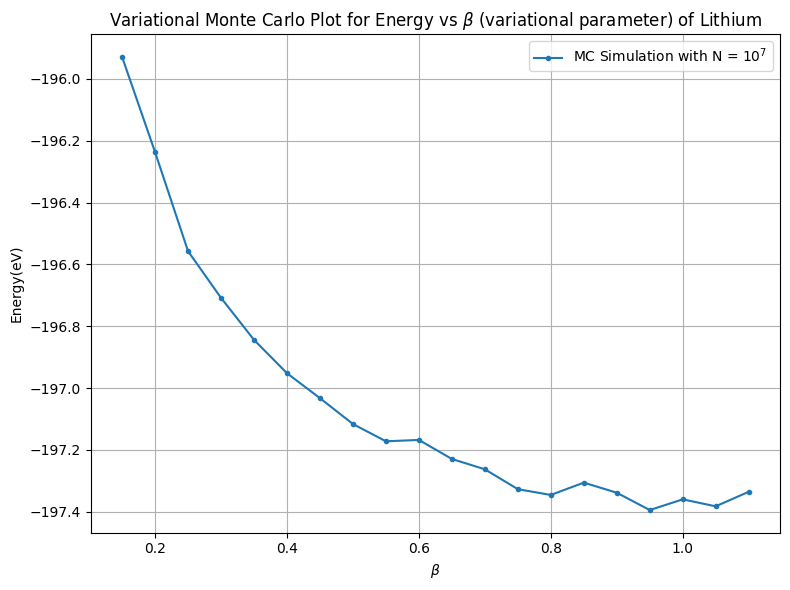

In [54]:
plt.figure(figsize=(8,6))
plt.plot(mean_list_3[:,0], 13.6*2*mean_list_3[:,1],'.-',label = 'MC Simulation with N = $10^7$')
plt.title('Variational Monte Carlo Plot for Energy vs $\\beta$ (variational parameter) of Lithium')
plt.xlabel('$\\beta$')
plt.ylabel('Energy(eV)')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

$\text{Both alpha and beta optimisation}$

In [32]:
number_cycles = 2*10**6  
step_length = 1.0
h = 0.001
h2 = 1 / h**2
number_particle = 2
dimension = 3
num_alpha = 10
num_beta = 10
charge = 3
alpha_values = np.linspace(2.3, 3.3, num_alpha)
beta_values = np.linspace(0.15, 1.0, num_beta)

r_old = step_length * (np.random.random((number_particle, dimension)) - 0.5)

results_3 = np.zeros((num_alpha * num_beta, 4))

index = 0
for alpha in tqdm(alpha_values, desc='Alpha loop'):
    for beta in beta_values:
        mean_energy, mean_sq_energy = metropolis_sample_t3(r_old.copy(), alpha, beta,charge ,step_length, number_cycles)
        variance = mean_sq_energy - mean_energy**2
        results_3[index] = np.array([alpha, beta, mean_energy, variance])
        index += 1


# print(results)

Alpha loop: 100%|██████████| 10/10 [00:59<00:00,  5.97s/it]


Optimal Value of alpha and beta are 2.855555555555555 and 0.5277777777777778
Minimum Energy Found =  -7.266100302796133


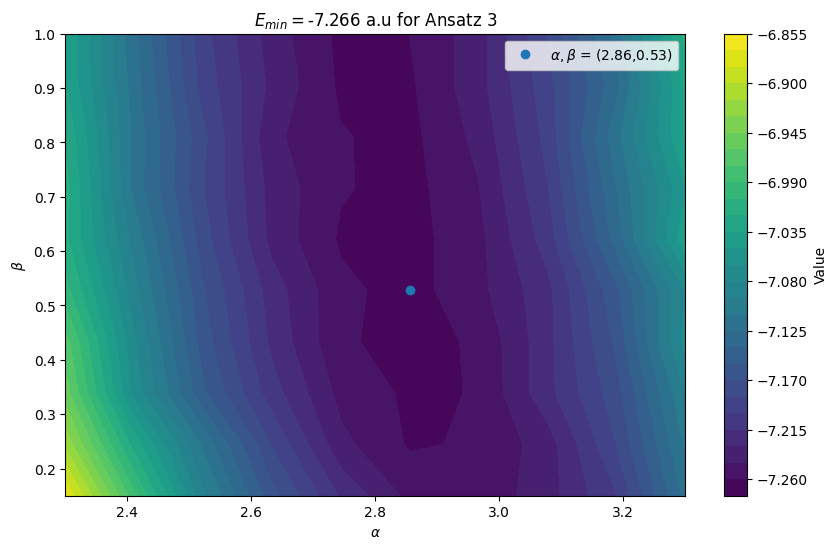

In [35]:
alpha_vals = results_3[:, 0]
beta_vals = results_3[:, 1]
energy_vals = results_3[:, 2]
unique_alpha = np.unique(alpha_vals)
unique_beta = np.unique(beta_vals)

Alpha, Beta = np.meshgrid(unique_alpha, unique_beta, indexing='ij')

energy_grid = energy_vals.reshape((len(unique_alpha), len(unique_beta)))

min_idx = np.argmin(energy_vals)
min_alpha_3 = alpha_vals[min_idx]
min_beta_3 = beta_vals[min_idx]
min_energy_3 = energy_vals[min_idx]
plt.figure(figsize=(10,6))
plt.contourf(Alpha,Beta,energy_grid,levels = 30)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('$E_{min} = $%0.3f a.u for Ansatz 3'%min_energy_3)
plt.plot(min_alpha_3,min_beta_3,'o',label = '$\\alpha,\\beta$ = (%0.2f,%0.2f)'%(min_alpha_3,min_beta_3))
plt.colorbar(label='Value')
# plt.text()
plt.legend()
print('Optimal Value of alpha and beta are',min_alpha_3,'and',min_beta_3)        
print('Minimum Energy Found = ',min_energy_3)

### $\text{Part D}$

Use the optimal value for all parameters and all wave functions to compute the expectation
value of the mean distance ⟨r12⟩ between the two electrons. Comment your results.

In [133]:
# For First Wavefunction
alpha_opt = 2.70

number_cycles = 10**7
step_length = 1.0
h = 0.001
h2 = 1 / h**2
number_particle = 2
dimension = 3
num_alpha = 15
# alpha = 1.3
r_old = step_length * (np.random.random((number_particle, dimension)) - 0.5)
mcs = 10**6
thermalisation = 1000
charge = 3
for i in range(thermalisation):
    r_new = r_old + (np.random.random((number_particle,dimension))- 0.5)*step_length
    wf_old = trial_wavefunc_t1(r_old,alpha_opt)
    wf_new = trial_wavefunc_t1(r_new,alpha_opt)

    if np.random.random() < (wf_new/wf_old)**2:
        r_old = r_new

r12 = 0
for i in tqdm(range(mcs)):
    r_new = r_old + (np.random.random((number_particle,dimension)) - 0.5)*step_length
    wf_old = trial_wavefunc_t1(r_old,alpha_opt)
    wf_new = trial_wavefunc_t1(r_new,alpha_opt)

    if np.random.random() < (wf_new/wf_old)**2:
        r_old = r_new
    r12 += sum((r_old[1] - r_old[0])**2)**0.5
 
print("Average distance between two particles :",r12/mcs)    

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [00:12<00:00, 81402.82it/s]

Average distance between two particles : 0.8094111532309817


In [57]:
# For Second Wavefunction
alpha_opt = min_alpha_2
beta_opt = min_beta_2
umber_cycles = 10**7
step_length = 1.0
h = 0.001
h2 = 1 / h**2
number_particle = 2
dimension = 3
num_alpha = 15
# alpha = 1.3
r_old = step_length * (np.random.random((number_particle, dimension)) - 0.5)
mcs = 10**6
thermalisation = 1000
charge = 3
for i in range(thermalisation):
    r_new = r_old + (np.random.random((number_particle,dimension))- 0.5)*step_length
    wf_old = trial_wavefunc_t2(r_old,alpha_opt,beta_opt)
    wf_new = trial_wavefunc_t2(r_new,alpha_opt,beta_opt)

    if np.random.random() < (wf_new/wf_old)**2:
        r_old = r_new

r12 = 0
for i in tqdm(range(mcs)):
    r_new = r_old + (np.random.random((number_particle,dimension)) - 0.5)*step_length
    wf_old = trial_wavefunc_t2(r_old,alpha_opt,beta_opt)
    wf_new = trial_wavefunc_t2(r_new,alpha_opt,beta_opt)

    if np.random.random() < (wf_new/wf_old)**2:
        r_old = r_new
    r12 += sum((r_old[1] - r_old[0])**2)**0.5
 
print("Average distance between two particles for ansatz 2:",r12/mcs)    

100%|██████████| 1000000/1000000 [00:09<00:00, 102027.19it/s]

Average distance between two particles for ansatz 2: 0.8510814335235878


In [58]:
# For Third Wavefunction
alpha_opt = min_alpha_3
beta_opt = min_beta_3
# number_cycles = 10**7
step_length = 1.0
h = 0.001
h2 = 1 / h**2
number_particle = 2
dimension = 3
num_alpha = 15
# alpha = 1.3
r_old = step_length * (np.random.random((number_particle, dimension)) - 0.5)
mcs = 10**6
thermalisation = 1000
charge = 3
for i in range(thermalisation):
    r_new = r_old + (np.random.random((number_particle,dimension))- 0.5)*step_length
    wf_old = trial_wavefunc_t3(r_old,alpha_opt,beta_opt)
    wf_new = trial_wavefunc_t3(r_new,alpha_opt,beta_opt)

    if np.random.random() < (wf_new/wf_old)**2:
        r_old = r_new

r12 = 0
for i in tqdm(range(mcs)):
    r_new = r_old + (np.random.random((number_particle,dimension)) - 0.5)*step_length
    wf_old = trial_wavefunc_t3(r_old,alpha_opt,beta_opt)
    wf_new = trial_wavefunc_t3(r_new,alpha_opt,beta_opt)

    if np.random.random() < (wf_new/wf_old)**2:
        r_old = r_new
    r12 += sum((r_old[1] - r_old[0])**2)**0.5
 
print("Average distance between two particles for 3rd wavefunction:",r12/mcs)   

100%|██████████| 1000000/1000000 [00:11<00:00, 86232.17it/s]

Average distance between two particles for 3rd wavefunction: 0.8397600381351086
